Gradings: 
44/50 Excellent work - I have had Jupyter overwrite work. Glad you managed to recover from it. 

- I had to edit the code a little to get it to run (e.g. importing tqdm) 

- More detail in the description at the start would help explain how you are approaching the problem. Figures with labels and legends look good 

- For SN the distance you want to use is luminosity distance - good deduction 

- Good use of chi-sq statistic to evaluate models 

- The input values for the data were H0=85, O_m=0.2, O_lambda=0.6 so nice work. The value of 85 is just on the edge of your solutions but this could be due to the large error bars and the fact that there might be small differences between the errors and the errors the model assumes. I liked the plot showing these differences. What does the value of chi-sq you estimate mean about the goodness of the fit. 

- Good work checking convergence. 

- Good choice of priors 

- Try documenting the code with docstrings when you write functions 

- Good description and comments in the code 

10+10+18+6

## Project 2: Fitting Cosmological Models to Observational Data

In [269]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import pi
from numpy import sin
from numpy import inf

import astropy.cosmology as cosmo
import numpy as np
from matplotlib import pyplot as plt
import astropy.units as u

import corner
from scipy.stats import chisquare

plt.rcParams["figure.figsize"] = [14, 10]

In [275]:
from astroML.plotting import hist, plot_mcmc
from astroML.plotting.mcmc import convert_to_stdev
from astroML.utils.decorators import pickle_results

import pymc3 as pm
import emcee

import warnings; warnings.simplefilter('ignore')

### Using astropy cosmology or your own program find the cosmological model that best fits a set of measurements of the distances to supernova. Read in the data from the file “SN.data”. The columns in this file are redshift, distance to a supernova (Mpc), and error on the distance to the supernova (Mpc).

### From these data:

#### a. Plot the redshift vs distance relation for the supernova data. Include error bars in your plot of the data.

In [260]:
# Importing the data and convert them into arrays

sn_table = pd.read_csv('SN_data.csv')
redshift = np.array(sn_table['Redshift'])
distance = np.array(sn_table['supernova_distance'])
distance_err = np.array(sn_table['supernova_distance_error'])

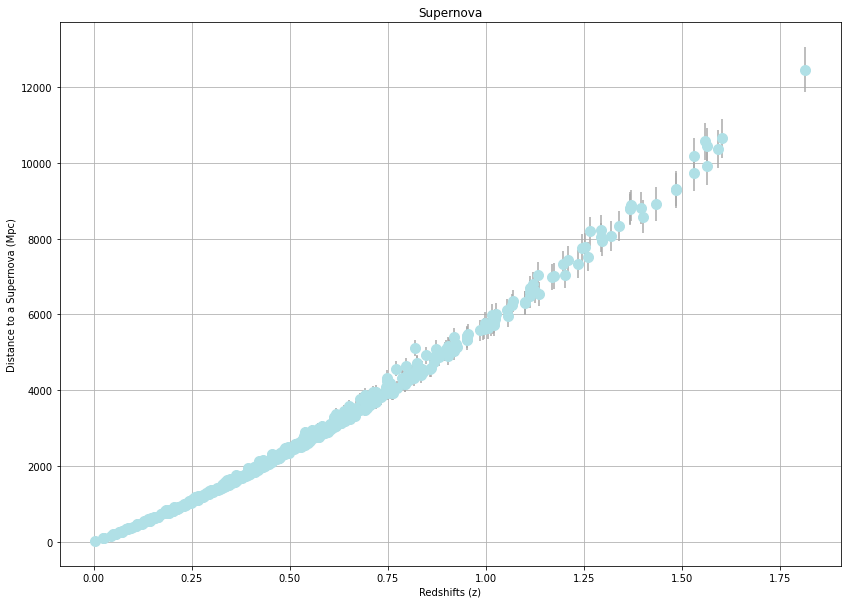

In [274]:
# Plotting the data

plt.scatter(redshift, distance, color = 'lightsteelblue')

plt.errorbar(redshift, distance, yerr = distance_err, 
             fmt ='o', markersize = 10, color = 'powderblue', ecolor = 'darkgrey')

plt.title('Supernova')
plt.xlabel('Redshifts (z)')
plt.ylabel('Distance to a Supernova (Mpc)')

plt.grid()

#### b. Find the cosmological model that best fits the data ( you should vary at least 3 cosmological parameters – e.g.$\Omega_m$, $\Omega_{\Lambda}$, $\Omega_k$ or $H_o$). When fitting your model to the data you should account for errors in the measurements. For example, you could use a $\chi^2$ statistic (e.g. $\chi^2 = \sum_i \frac{(x_i -f(\Omega_m, \Omega_{\Lambda}, \Omega_k))^2}{\sigma^2_i})$ to evaluate the goodness of your fit to the data.

### Setting up MCMC using ASTR 324 notes

- Setting up initial conditions and constraints with prior and chi square function
- Setting up the likelihood and posterior to run the MCMC chain

In [210]:
# Defining the functions for the MCMC chain later

def cos_model(H, M, L, z):
    uni = cosmo.LambdaCDM(H0=H, Om0 =M, Ode0=L)
    lumi_d = uni.luminosity_distance(z)
    return lumi_d

def chi_square_fn(o, e, err):
    result = np.sum(((o-e)**2)/(err**2))
    return result

def prior(theta):
    M, L, H = theta
    if (0<M<1 and 0<L<2 and 40<H<200):
        return 0
    else:
        return -inf
    
def likelihood(theta, data):
    M, L, H = theta
    if (0<M<1 and 0<L<2 and 40<H<200):
        uni = cosmo.LambdaCDM(H0=H,Om0=M,Ode0=L)
        expected = (uni.luminosity_distance(redshift)).value
        chi_2 = chi_square_fn(distance, expected, distance_err)
        return -chi_2
    else:
        return -inf
    
def posterior(param, data):
    logpos = prior(param) + likelihood(param, data)
    return logpos  

In [245]:
# MCMC pipeline and setting the parameters

# Number of parameters in the model
ndim = 3

# Number of walkers
nwalkers = 30

# Burn off 1100 periods to let the chain stabilize
Nburn = 1100  

# Number of MCMC steps
nsteps = 12000 

# Initialize guess data theta = [Ω_m, Ω_Λ, H_0]
theta = [0.22, 0.64, 82]

# Create multiple starting positions with some random offset from theta.
initial = np.array(theta + 0.001 * np.random.rand(nwalkers, ndim)) 

# set up the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, posterior, args=[sn_table])

# Run the sampler starting at the initial position taking nSteps and showing progress towars completion
sampler.run_mcmc(initial, nSteps, progress = True) 

# Flatten the sampler to get the data for the corner plot
samples_flat = sampler.get_chain(discard = Nburn, thin = 50, flat=True)

print('Done')

You must install the tqdm library to use progress indicators with emcee


Done


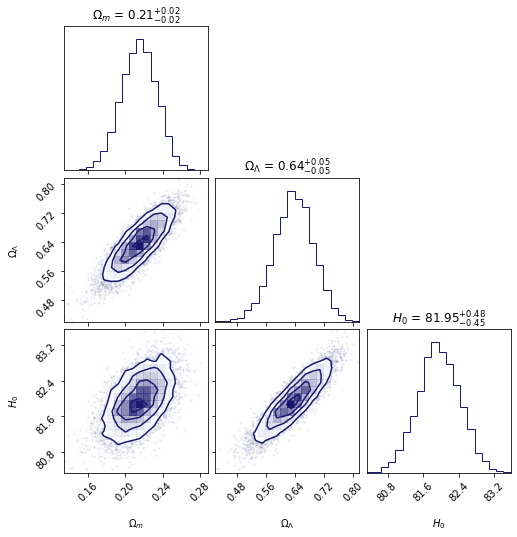

In [246]:
# Cornor plot showing the best fits and it's uncertanties

corner.corner(samples_flat, 
              show_titles = True, 
              color = 'midnightblue',
              labels=[r'$\Omega_{m}$',r'$\Omega_{\Lambda}$', r'$H_{0}$']);

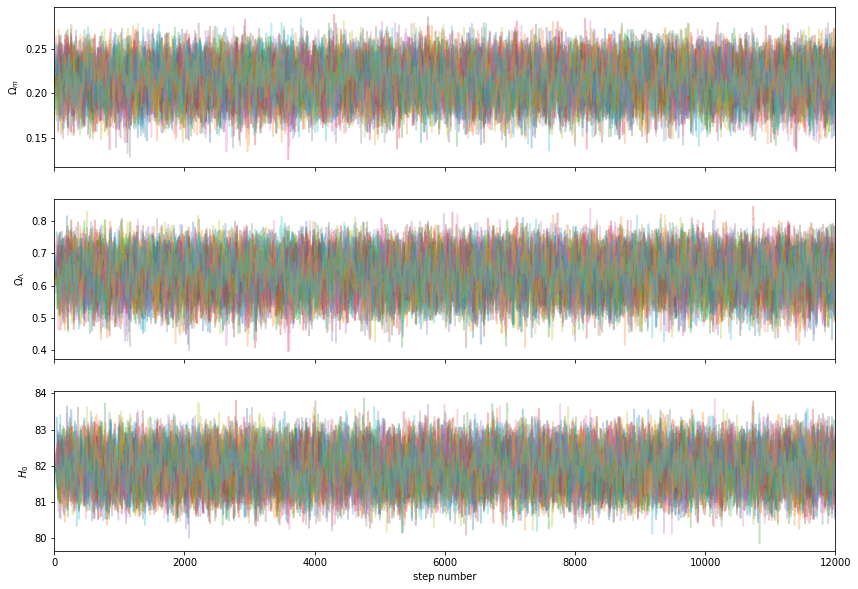

In [247]:
# MCMC walks: showing the paths of walkers converges

samples = sampler.get_chain()
labels = [r'$\Omega_{m}$',r'$\Omega_{\Lambda}$', r'$H_{0}$']

fig, ax = plt.subplots(3, sharex=True)

plt.xlabel("step number")
plt.xlim(0, nsteps)
for i in range(ndim):
    ax[i].plot(samples[:, :, i], alpha=0.3)
    ax[i].set_ylabel(labels[i])

#### c. Your best fit model should include an estimate of the uncertainties in the derived cosmological parameters (using for example the $\chi^2$ to estimate this).

In [249]:
# Creating a cosmology model using the best fits. Using the luminosity distance because it's the supernova data

uni_fit = cosmo.LambdaCDM(H0=81.95, Om0 =0.21, Ode0=0.64)
distance_fit = uni.luminosity_distance(redshift)

chi_square = chi_square_fn(np.array(distance), np.array(distance_fit), np.array(distance_err))
chi = (chi_square)**(1/2)
chi

13.405880249792549

#### d. Plot the redshift-distance relation for your best fitting model on top of the supernova data

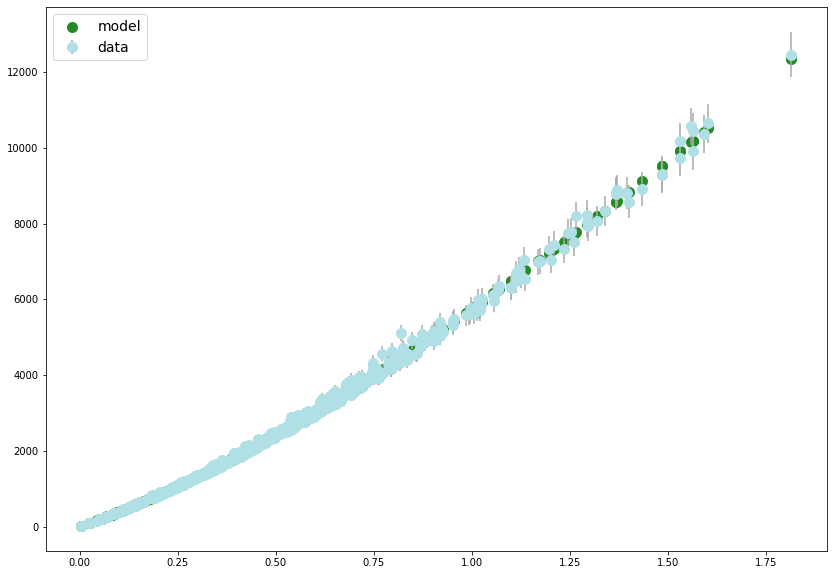

In [271]:
# Plotting the fit model and the model seems to fit the experimental data closely
# But still not perfectly aligns because we only constrained 3 parameters

plt.errorbar(redshift, distance, yerr = distance_err, fmt ='o', markersize = 10,
             color = 'powderblue', ecolor = 'darkgrey', label = 'data')

plt.scatter(redshift, distance_fit, color = 'forestgreen', linewidths = 5, label = 'model')

plt.legend(loc='upper left', fontsize=14)

#### e. Plot the uncertainties for the 3 cosmological parameters you used in your model. Plot this as a “corner plot” (see below) showing the one and two σ uncertainty contours for the cosmological parameters.

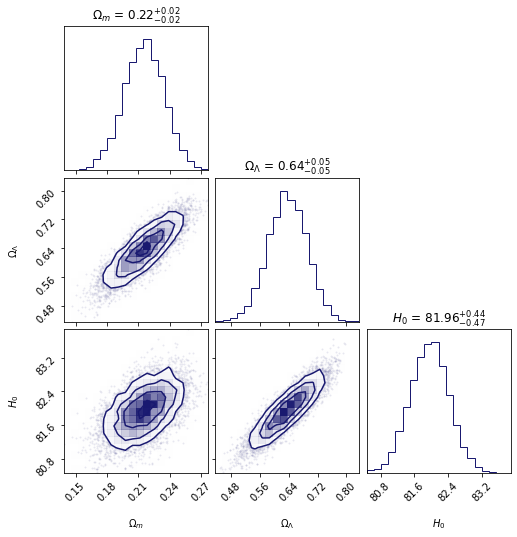

In [273]:
# Corner plot showing the correlation of the parameters and the uncertainties

corner.corner(flatSamples, 
              show_titles = True, 
              color = 'midnightblue',
              labels=[r'$\Omega_{m}$',r'$\Omega_{\Lambda}$', r'$H_{0}$']);

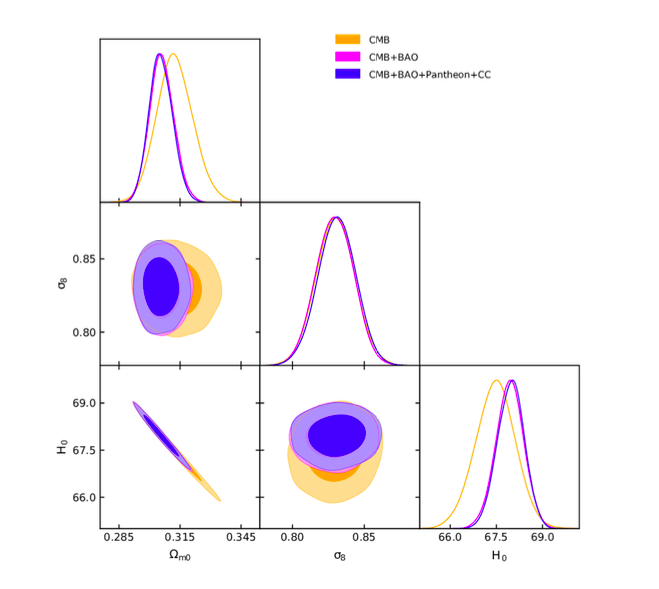